This is a simplified version of my 18th place solution in the **Shopee - Price Match Guarantee** contest


I replaced my image models with resnet18 to showcase that even a very basic model could do well and was enough to score a silver medal in this competition

UPDATE: I also incorporated embeddings blending from the 1st place solution described [here](https://www.kaggle.com/c/shopee-product-matching/discussion/238136) and extraction of units of measurements inspired by [this kernel](https://www.kaggle.com/readoc/extract-measurements-feature-engineering). All this together scored .772 (762 private) which would have placed it in the top 10 - still using just a single resnet18 + BERT (trained on 80% of the train data)

# An outline of the (updated) approach

### Step 1 training 
**I used arcface for all my training**, and fine tune pretrained models with it for a few epochs. For image I tried resnet, efficient net and nfnet. The nfnet worked the best for me so that’s in my final solution. The resnet18 I used in the toy solution just to show a very basic model can work too. 

For text I found that a language model pretrained on Indonesian language worked the best.

### Step 2 Embeddings and similarities 
For both models I first generate embedddings and then find the top 50 nearest neighbours for each row.

### Step 3 Combine the model outputs
I combine the neighbours from the previous step with formula D = D<sub>Resnet</sub> + D<sub>BERT</sub> - D<sub>Resnet</sub> * D<sub>BERT</sub>

This I found works much better than alternatives of taking mean or max.

### Step 4 Blending
I perform a single step of [Neighborhood Blending](https://www.kaggle.com/c/shopee-product-matching/discussion/238136)
This represented a jump in score from .749 to .770

### Step 5 Unmatching based on measurements units
I remove close matches that differ with measurement units in description ie 150ml vs 300ml.
This improved the score .770 -> .772

### Step 6 force groups into a desired distribution 
This was a largest single change I made, jumping my score from .739 to .759
I nicknamed it “chiseling” the idea is: I first make an educated guess that the distribution of group targets in the test data is similar to the one in train. Then I remove matches until my submission has the same shape.






In [1]:
from tqdm.notebook import tqdm
import sklearn.feature_extraction.text
from transformers import BertTokenizer, AutoConfig, AutoModel
from sklearn.model_selection import StratifiedKFold
import regex
import torch

In [2]:
PATH = '../input/shopee-product-matching'

BERT_PATH = '../input/bertindo15g'
bert_model_file = '../input/shopee-small-models/bert_indo_val0.pth'

image_model_file = '../input/shopee-small-models/resnet18val0.pth'


In [3]:
# thees are thresholds used for Neighborhood Blending
RECIPROCAL_THRESHOLD = .97
MIN_PAIR_THRESHOLD = .6

## Bert Model

In [4]:
class BertTextModel(nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert_model = bert_model
        
    def forward(self, x):
        output = self.bert_model(*x)
        return output.last_hidden_state[:,0,:]

In [5]:
def load_bert_model(fname):
    model = AutoModel.from_config(AutoConfig.from_pretrained(BERT_PATH))
    state = torch.load(fname)
    model.load_state_dict(state)
    return BertTextModel(model).cuda().eval()

### Dataloader for Bert

In [6]:
#Taken from https://www.kaggle.com/c/shopee-product-matching/discussion/233605#1278984
def string_escape(s, encoding='utf-8'):
    return s.encode('latin1').decode('unicode-escape').encode('latin1').decode(encoding)

class TitleTransform(Transform):
    def __init__(self):
        super().__init__()
        self.tokenizer = BertTokenizer.from_pretrained(BERT_PATH)
               
    def encodes(self, row):
        text = row.title
        text=string_escape(text)
        encodings = self.tokenizer(text, padding = 'max_length', max_length=100, truncation=True,return_tensors='pt')
        keys =['input_ids', 'attention_mask', 'token_type_ids'] 
        return tuple(encodings[key].squeeze() for key in keys)

def get_text_dls():
    tfm = TitleTransform()

    data_block = DataBlock(
        blocks = (TransformBlock(type_tfms=tfm), 
                  CategoryBlock(vocab=train_df.label_group.to_list())),
        splitter=ColSplitter(),
        get_y=ColReader('label_group'),
        )
    return  data_block.dataloaders(train_df, bs=256)

## IMAGE

In [7]:
class ResnetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = create_body(resnet18, cut=-2, pretrained=False)
        self.after_conv=nn.Sequential(
            AdaptiveConcatPool2d(),
            Flatten(),
            nn.BatchNorm1d(1024)
        )
    def forward(self, x):
        x = self.body(x)
        return self.after_conv(x)
        

In [8]:
def load_image_model(fname):
    state_dict = torch.load(fname)
    model = ResnetModel()
    model.load_state_dict(state_dict)
    model = model.eval().cuda()
    return model

In [9]:
def get_img_file(row):
    img =row.image
    fn  = PATH/'train_images'/img
    if not fn.is_file():
        fn = PATH/'test_images'/img
    return fn

def get_image_dls(size, bs):
    data_block = DataBlock(blocks = (ImageBlock(), CategoryBlock(vocab=train_df.label_group.to_list())),
                 splitter=ColSplitter(),
                 get_y=ColReader('label_group'),
                 get_x=get_img_file,
                 item_tfms=Resize(int(size*1.5), resamples=(Image.BICUBIC,Image.BICUBIC)), 
                 batch_tfms=aug_transforms(size=size, min_scale=0.75)+[Normalize.from_stats(*imagenet_stats)],
                 )
    return data_block.dataloaders(train_df, bs=bs)



## Helper code

In [11]:

def add_target_groups(data_df, source_column='label_group', target_column='target'):
    target_groups = data_df.groupby(source_column).indices
    data_df[target_column]=data_df[source_column].map(target_groups)
    return data_df

def add_splits(train_df, valid_group=0):
    grouped = train_df.groupby('label_group').size()

    labels, sizes =grouped.index.to_list(), grouped.to_list()

    skf = StratifiedKFold(5)
    splits = list(skf.split(labels, sizes))

    group_to_split =  dict()
    for idx in range(5):
        labs = np.array(labels)[splits[idx][1]]
        group_to_split.update(dict(zip(labs, [idx]*len(labs))))

    train_df['split'] = train_df.label_group.replace(group_to_split)
    train_df['is_valid'] = train_df['split'] == valid_group
    return train_df

def embs_from_model(model, dl):
    all_embs = []
    all_ys=[]
    for batch in tqdm(dl):
        if len(batch) ==2:
            bx,by=batch
        else:
            bx,=batch
            by=torch.zeros(1)
        with torch.no_grad():
            embs = model(bx)
            all_embs.append(embs.half())
        all_ys.append(by)
    all_embs = F.normalize(torch.cat(all_embs))
    return all_embs, torch.cat(all_ys)

def get_targets_shape(train_df):
    all_targets = add_target_groups(train_df).target.to_list()
    all_targets_lens = [len(t) for t in all_targets]
    targets_shape = []
    for size in range(min(all_targets_lens), max(all_targets_lens)+1):
        count = all_targets_lens.count(size) / len(all_targets)
        targets_shape.append((size,count))
    return targets_shape

def chisel(groups, groups_p, pos, target_count):
    probs = []
    groups_lens = [len(g)for g in groups]
    current_count = groups_lens.count(pos)
    if current_count >= target_count:

        return
    to_cut = target_count - current_count
    for i in range(len(groups)):
        if len(groups_p[i])>pos:
            probs.append((i, groups_p[i][pos]))
    probs.sort(key=lambda x:x[1])
    for i in range(min(to_cut, len(probs))):
        group_idx = probs[i][0] 
        groups[group_idx]=groups[group_idx][:pos]
        groups_p[group_idx]=groups_p[group_idx][:pos]

In [12]:

def sorted_pairs(distances, indices):
    triplets = []
    n= len(distances)
    for x in range(n):
        used=set()
        for ind, dist in zip(indices[x].tolist(), distances[x].tolist()):
            if not ind in used:
                triplets.append((x, ind, dist))
                used.add(ind)
    return sorted(triplets, key=lambda x: -x[2])
def do_chunk(embs):
    step = 1000
    for chunk_start in range(0, embs.shape[0], step):
        chunk_end = min(chunk_start+step, len(embs))
        yield embs[chunk_start:chunk_end]
def get_nearest(embs, emb_chunks, K=None, sorted=True):
    if K is None:
        K = min(51, len(embs))
    distances = []
    indices = []
    for chunk in emb_chunks:
        sim = embs @ chunk.T
        top_vals, top_inds = sim.topk(K, dim=0, sorted=sorted)
        distances.append(top_vals.T)
        indices.append(top_inds.T)
    return torch.cat(distances), torch.cat(indices)

def combined_distances(embs_list):
    K = min(len(embs_list[0]), 51)
    combined_inds =[get_nearest(embs, do_chunk(embs))[1] for embs in embs_list]
    combined_inds = torch.cat(combined_inds, dim=1)
    res_inds,res_dists = [],[]
    for x in range(len(combined_inds)):
        inds = combined_inds[x].unique()
        Ds = [embs[None,x] @ embs[inds].T for embs in embs_list]
        D = Ds[0] + Ds[1] - Ds[0] * Ds[1]
        top_dists, top_inds = D.topk(K)
        res_inds.append(inds[top_inds])
        res_dists.append(top_dists)
    return torch.cat(res_inds), torch.cat(res_dists)

def blend_embs(embs_list, threshold, m2_threshold, data_df):
    combined_inds, combined_dists = combined_distances(embs_list)
    check_measurements(combined_dists, combined_inds, data_df)
    new_embs_list = L((torch.empty_like(embs) for embs in embs_list))
    for x in range(len(embs_list[0])):
        neighs = combined_dists[x] > threshold
        if neighs.sum() == 1 and combined_dists[x][1]>m2_threshold:
            neighs[1]=1
        neigh_inds, neigh_ratios = combined_inds[x, neighs], combined_dists[x,neighs]
        for embs, new_embs in zip(embs_list, new_embs_list):
            new_embs[x] = (embs[neigh_inds] * neigh_ratios.view(-1,1)).sum(dim=0)
    return new_embs_list.map(F.normalize)

In [13]:
# Not used in solution, just for illustration purpose
def f1(tp, fp, num_tar):
    return 2 * tp / (tp+fp+num_tar)

def build_from_pairs(pairs, target, display = True):
    score =0
    tp = [0]*len(target)
    fp = [0]*len(target)
    scores=[]
    vs=[]
    group_sizes = [len(x) for x in target]
    for x, y, v in pairs:
        group_size = group_sizes[x]
        score -= f1(tp[x], fp[x], group_size)
        if y in target[x]: tp[x] +=1
        else: fp[x] +=1
        score += f1(tp[x], fp[x], group_size) 
        scores.append(score / len(target))
        vs.append(v)
    if display:
        plt.plot(scores)
        am =torch.tensor(scores).argmax()
        print(f'{scores[am]:.3f} at {am/len(target)} pairs or {vs[am]:.3f} threshold')
    return scores


def score_distances(dist, targets, display=False):
    triplets = dist_to_edges(dist)[:len(dist)*10]
    return max(build_from_pairs(triplets, targets, display))

def score_group(group, target):
    tp = len(set(group).intersection(set(target)))
    return 2 * tp / (len(group)+len(target))
def score_all_groups(groups, targets):
    scores = [score_group(groups[i], targets[i]) for i in range(len(groups))]
    return sum(scores)/len(scores)
def show_groups(groups, targets):
    groups_lens = [len(g)for g in groups]
    targets_lens = [len(g) for g in targets]
    plt.figure(figsize=(8,8)) 
    plt.hist((groups_lens,targets_lens) ,bins=list(range(1,52)), label=['preds', 'targets'])
    plt.legend()
    plt.title(f'score: {score_all_groups(groups, targets):.3f}')
    plt.show()

### Helper code for units of measurement matching

In [14]:
measurements = {
    'weight': [('mg',1), ('g', 1000), ('gr', 1000), ('gram', 1000), ('kg', 1000000)],
    'length': [('mm',1), ('cm', 10), ('m',1000), ('meter', 1000)],
    'pieces': [ ('pc',1)],
    'memory': [('gb', 1)],
    'volume': [('ml', 1), ('l', 1000), ('liter',1000)]
}

def to_num(x, mult=1):
    x = x.replace(',','.')
    return int(float(x)*mult)

def extract_unit(tit, m):
    pat = f'\W(\d+(?:[\,\.]\d+)?) ?{m}s?\W'
    matches = regex.findall(pat, tit, overlapped=True)
    return set(matches)

def extract(tit):

    res =dict()
    tit = ' '+tit.lower()+' '
    for cat, units in measurements.items():
        cat_values=set()
        for unit_name, mult in units:
            values = extract_unit(tit, unit_name)
            values = {to_num(v, mult) for v in values}
            cat_values = cat_values.union(values)
        if cat_values:
            res[cat] = cat_values
    return res

def add_measurements(data):
    data['measurement'] = data.title.map(extract)
    return data

def match_measures(m1, m2):
    k1,k2 = set(m1.keys()), set(m2.keys())
    common = k1.intersection(k2)
    if not common: return True
    for key in common:
        s1,s2 = m1[key], m2[key]
        if s1.intersection(s2):
            return True
    return False

def check_measurements(combined_dists, combined_inds, data_df):
    K = min(8, len(data_df)) * len(data_df)
    _, inds_k = combined_dists.view(-1).topk(K)
    removed = 0
    inds_k = inds_k.tolist()
    for idx in inds_k:
        x = idx // combined_inds.shape[1]
        y_idx = idx % combined_inds.shape[1]
        y = combined_inds[x,y_idx] 
        if not match_measures(data_df.iloc[x].measurement, data_df.iloc[y.item()].measurement):
            removed +=1
            combined_dists[x][y_idx]=0
    print('removed', removed, 'matches')

## Check on validation set

In [15]:
train_df = pd.read_csv(PATH/'train.csv')
train_df = add_splits(train_df)

valid_df = train_df[train_df.is_valid==True].reset_index()
valid_df=add_measurements(valid_df)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


### Generating embeddings from Resnet and BERT

In [16]:
img_embs,ys = embs_from_model(load_image_model(image_model_file), get_image_dls(224,256).valid)

bert_embs, ys = embs_from_model(load_bert_model(bert_model_file), get_text_dls().valid)

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

**This is the score we'd get by simply taking all matches above a fixed threshold:**

0.883 at 5.934617519378662 pairs or 0.766 threshold


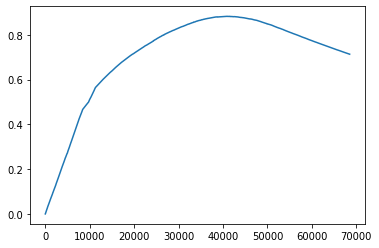

In [17]:
set_size = len(img_embs)
target_matrix= ys[:,None]==ys[None,:]
targets = [torch.where(t)[0].tolist() for t in target_matrix] 

combined_inds, combined_dists = combined_distances([img_embs, bert_embs])
pairs = sorted_pairs(combined_dists, combined_inds)
_=build_from_pairs(pairs[:10*len(combined_inds)], targets)

0.883 at 5.934617519378662 pairs or 0.766 threshold


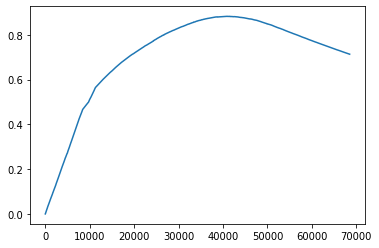

In [ ]:
set_size = len(img_embs)
target_matrix= ys[:,None]==ys[None,:]
targets = [torch.where(t)[0].tolist() for t in target_matrix] 

combined_inds, combined_dists = combined_distances([img_embs, bert_embs])
pairs = sorted_pairs(combined_dists, combined_inds)
_=build_from_pairs(pairs[:10*len(combined_inds)], targets)

0.883 at 5.934617519378662 pairs or 0.766 threshold


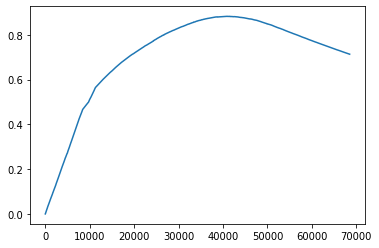

In [ ]:
set_size = len(img_embs)
target_matrix= ys[:,None]==ys[None,:]
targets = [torch.where(t)[0].tolist() for t in target_matrix] 

combined_inds, combined_dists = combined_distances([img_embs, bert_embs])
pairs = sorted_pairs(combined_dists, combined_inds)
_=build_from_pairs(pairs[:10*len(combined_inds)], targets)

0.883 at 5.934617519378662 pairs or 0.766 threshold


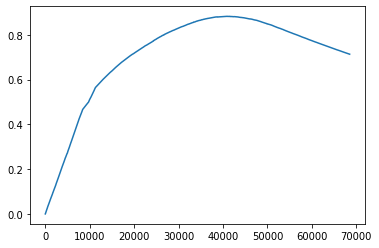

In [ ]:
set_size = len(img_embs)
target_matrix= ys[:,None]==ys[None,:]
targets = [torch.where(t)[0].tolist() for t in target_matrix] 

combined_inds, combined_dists = combined_distances([img_embs, bert_embs])
pairs = sorted_pairs(combined_dists, combined_inds)
_=build_from_pairs(pairs[:10*len(combined_inds)], targets)

0.883 at 5.934617519378662 pairs or 0.766 threshold


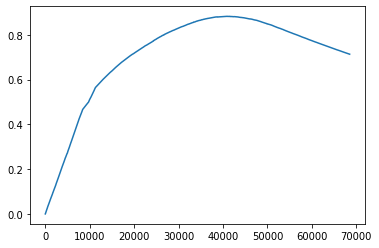

In [ ]:
set_size = len(img_embs)
target_matrix= ys[:,None]==ys[None,:]
targets = [torch.where(t)[0].tolist() for t in target_matrix] 

combined_inds, combined_dists = combined_distances([img_embs, bert_embs])
pairs = sorted_pairs(combined_dists, combined_inds)
_=build_from_pairs(pairs[:10*len(combined_inds)], targets)

0.883 at 5.934617519378662 pairs or 0.766 threshold


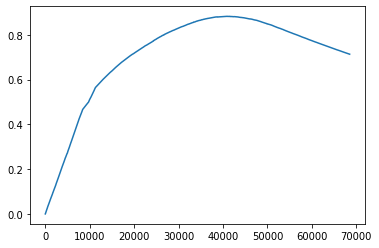

In [ ]:
set_size = len(img_embs)
target_matrix= ys[:,None]==ys[None,:]
targets = [torch.where(t)[0].tolist() for t in target_matrix] 

combined_inds, combined_dists = combined_distances([img_embs, bert_embs])
pairs = sorted_pairs(combined_dists, combined_inds)
_=build_from_pairs(pairs[:10*len(combined_inds)], targets)

0.883 at 5.934617519378662 pairs or 0.766 threshold


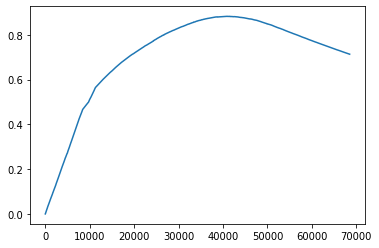

In [ ]:
set_size = len(img_embs)
target_matrix= ys[:,None]==ys[None,:]
targets = [torch.where(t)[0].tolist() for t in target_matrix] 

combined_inds, combined_dists = combined_distances([img_embs, bert_embs])
pairs = sorted_pairs(combined_dists, combined_inds)
_=build_from_pairs(pairs[:10*len(combined_inds)], targets)

**This is the score after Neighborhood Blending:**

In [ ]:
new_embs = blend_embs([img_embs, bert_embs], RECIPROCAL_THRESHOLD, MIN_PAIR_THRESHOLD, valid_df)

combined_inds, combined_dists = combined_distances(new_embs)
pairs = sorted_pairs(combined_dists, combined_inds)
_=build_from_pairs(pairs[:10*len(combined_inds)], targets)

### Removing false positives based on measurements

In [ ]:
check_measurements(combined_dists, combined_inds, valid_df)
pairs = sorted_pairs(combined_dists, combined_inds)
_=build_from_pairs(pairs[:10*len(combined_inds)], targets)

### Here we perform the chisel step to match the two distributions
This doesn't help here where we already have good matches, the effect is more pronounced on the test set where the initial grouping is further apart from the target

In [ ]:
groups = [[] for _ in range(set_size)]
groups_p = [[] for _ in range(set_size)]
for x,y,v in pairs:
    groups[x].append(y)
    groups_p[x].append(v)
for pos, size_pct in get_targets_shape(train_df):
    chisel(groups, groups_p, pos, int(size_pct * len(groups)))
show_groups(groups, targets)

## Run on the test set
same as above, just without displaying stuff.

In [ ]:
test_df = pd.read_csv(PATH/'test.csv')
test_df = add_measurements(test_df)

In [ ]:
TRIAL_RUN=False

if TRIAL_RUN:
    fake_test_df = train_df[['posting_id', 'image', 'image_phash', 'title', 'label_group']].copy()
    fake_test_df = pd.concat([fake_test_df, fake_test_df])
    fake_test_df = add_target_groups(fake_test_df)
    test_df = fake_test_df

In [ ]:
bert_embs,_ = embs_from_model(load_bert_model(bert_model_file), get_text_dls().test_dl(test_df))

img_embs,_ =embs_from_model(load_image_model(image_model_file), get_image_dls(224, 256).test_dl(test_df))

In [ ]:
set_size = len(img_embs)

In [ ]:
%%time
new_embs = blend_embs([img_embs, bert_embs], RECIPROCAL_THRESHOLD, MIN_PAIR_THRESHOLD, test_df)


In [ ]:
combined_inds, combined_dists = combined_distances(new_embs)

In [ ]:
check_measurements(combined_dists, combined_inds, test_df)

In [ ]:
pairs = sorted_pairs(combined_dists, combined_inds)

In [ ]:
groups = [[] for _ in range(set_size)]
groups_p = [[] for _ in range(set_size)]
for x,y,v in pairs:
    groups[x].append(y)
    groups_p[x].append(v)
for pos, size_pct in get_targets_shape(train_df):
    chisel(groups, groups_p, pos, int(size_pct * len(groups)))

In [ ]:
matches = [' '.join(test_df.iloc[g].posting_id.to_list()) for g in groups]
test_df['matches'] = matches

test_df[['posting_id','matches']].to_csv('submission.csv',index=False)

In [ ]:
pd.read_csv('submission.csv').head()
#list the highest similarity result